#  Importing the Necessary Libraries

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import datetime

# Setting plot style
sns.set(style='whitegrid')

#  Load the Dataset

In [5]:
# Load the dataset
df = pd.read_csv("P:\\uber.csv")

In [7]:
# Display the first few rows of the dataset
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


#  Dataset Description and Cleanup

In [10]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [12]:
# Checking for missing values
print(df.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


In [14]:
# Dropping rows with missing values
df = df.dropna()

In [16]:
# Ensure fare_amount is positive
df = df[df['fare_amount'] > 0]

# Ensuring reasonable passenger count (assuming 1-6 passengers)
df = df[(df['passenger_count'] >= 1) & (df['passenger_count'] <= 6)]

# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

#  Exploratory Data Analysis (EDA)

In [19]:
# Basic statistics of the dataset
df.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.992680e+05,199268.000000,199268.000000,199268.000000,199268.000000,199268.000000,199268.000000
mean,2.771561e+07,11.369418,-72.530113,39.937182,-72.528142,39.925350,1.689438
std,1.601418e+07,9.905877,11.434234,7.723680,13.119047,6.794163,1.305387
min,1.000000e+00,0.010000,-1340.648410,-74.015515,-3356.666300,-881.985513,1.000000
25%,1.382627e+07,6.000000,-73.992065,40.734796,-73.991410,40.733828,1.000000
50%,2.775597e+07,8.500000,-73.981825,40.752584,-73.980095,40.753041,1.000000
75%,4.155982e+07,12.500000,-73.967162,40.767157,-73.963664,40.767995,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,6.000000


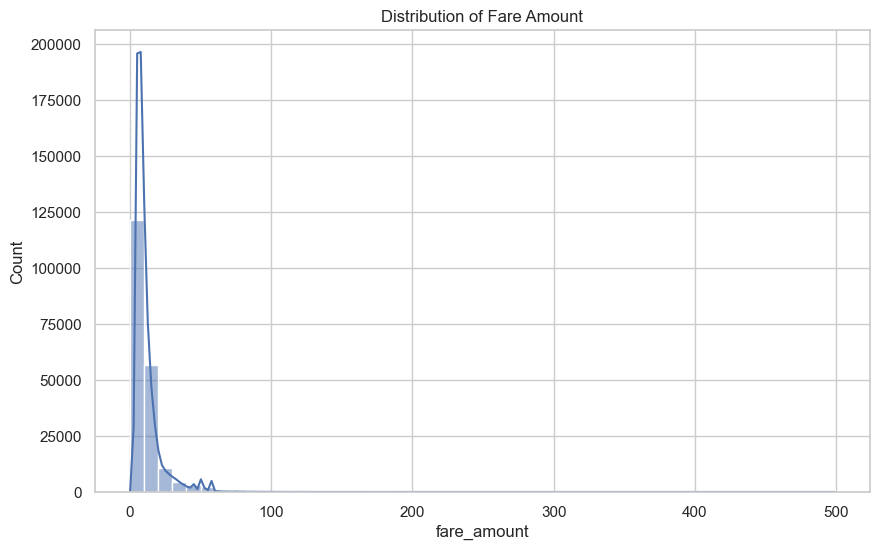

In [21]:
# Distribution of fare_amount
plt.figure(figsize=(10,6))
sns.histplot(df['fare_amount'], bins=50, kde=True)
plt.title('Distribution of Fare Amount')
plt.show()

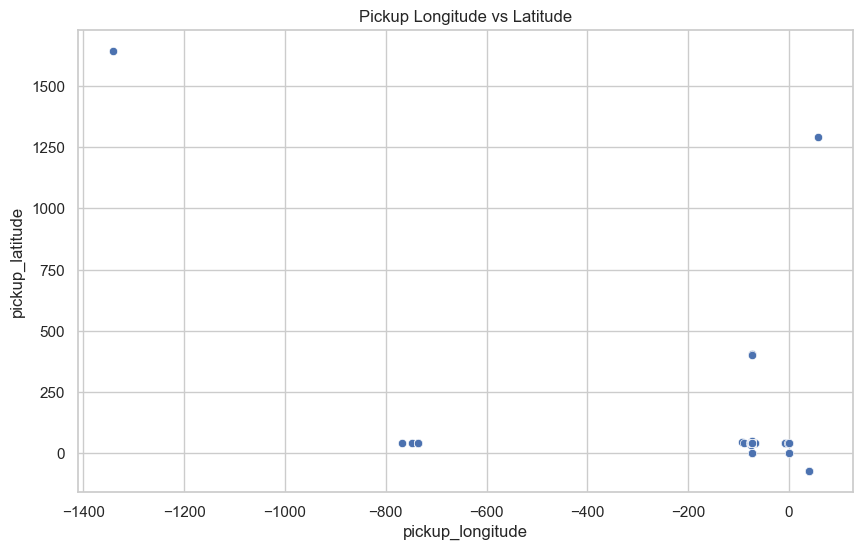

In [23]:
# Scatter plot of pickup longitude vs. pickup latitude (to check outliers)
plt.figure(figsize=(10,6))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df)
plt.title('Pickup Longitude vs Latitude')
plt.show()

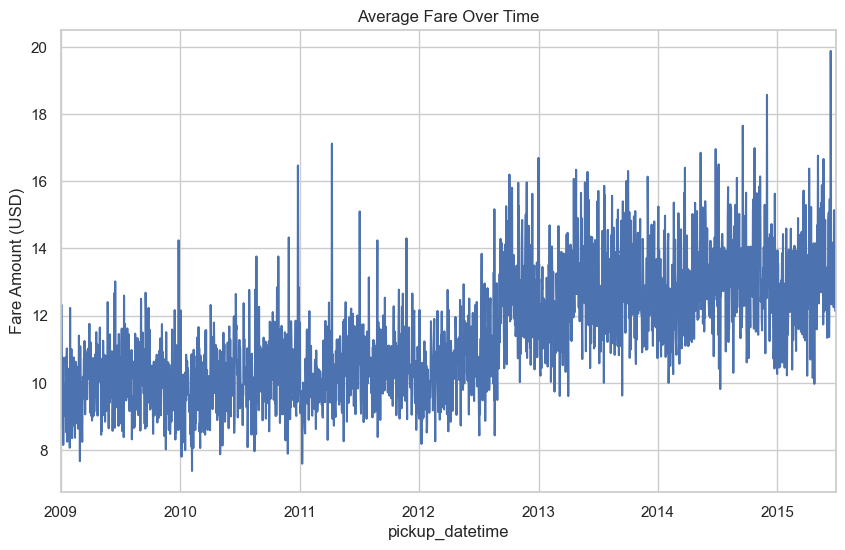

In [25]:
# Time-based analysis: fares over time
df.set_index('pickup_datetime', inplace=True)
df['fare_amount'].resample('D').mean().plot(figsize=(10,6), title='Average Fare Over Time')
plt.ylabel('Fare Amount (USD)')
plt.show()

In [27]:
# Reset index for further processing
df.reset_index(inplace=True)

#  Feature Engineering

In [30]:
# Feature extraction from pickup_datetime
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek

In [32]:
# Haversine formula to calculate distance between pickup and dropoff locations
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [34]:
# Adding a distance feature
df['distance_km'] = haversine(df['pickup_longitude'], df['pickup_latitude'],
                              df['dropoff_longitude'], df['dropoff_latitude'])

In [36]:
# Checking the updated dataframe
df.head()

,pickup_datetime,Unnamed: 0,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,distance_km
0,2015-05-07 19:52:06+00:00,24238194,2015-05-07 19:52:06.0000003,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,3,1.683323
1,2009-07-17 20:04:56+00:00,27835199,2009-07-17 20:04:56.0000002,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,2.457590
2,2009-08-24 21:45:00+00:00,44984355,2009-08-24 21:45:00.00000061,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,0,5.036377
3,2009-06-26 08:22:21+00:00,25894730,2009-06-26 08:22:21.0000001,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,4,1.661683
4,2014-08-28 17:47:00+00:00,17610152,2014-08-28 17:47:00.000000188,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,3,4.475450


#  Split Data into Training and Test Sets

In [39]:
# Drop irrelevant columns
X = df[['passenger_count', 'distance_km', 'year', 'month', 'day', 'hour', 'day_of_week']]
y = df['fare_amount']

# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  Build Regression Models

#  1. Linear Regression Model

In [43]:
# Initialize and train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [45]:
# Predicting and evaluating
y_pred_lr = lr_model.predict(X_test)

In [47]:
# Metrics
print("Linear Regression R2 Score:", r2_score(y_test, y_pred_lr))
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

Linear Regression R2 Score: 0.014743537280968999
Linear Regression RMSE: 10.111564147848746


#  2. Random Forest Regressor

In [50]:
# Initialize and train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [51]:
# Predicting and evaluating
y_pred_rf = rf_model.predict(X_test)

In [52]:
# Metrics
print("Random Forest R2 Score:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

Random Forest R2 Score: 0.7087073404073951
Random Forest RMSE: 5.498047222149707


#  3. Lasso Regression

In [55]:
# Initialize and train Lasso Regression model
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)

,alpha,0.1
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [56]:
# Predicting and evaluating
y_pred_lasso = lasso_model.predict(X_test)

In [57]:
# Metrics
print("Lasso Regression R2 Score:", r2_score(y_test, y_pred_lasso))
print("Lasso Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lasso)))

Lasso Regression R2 Score: 0.014633358310657929
Lasso Regression RMSE: 10.112129508556155


#  Time Series Analysis

#  1. Exponential Smoothing

In [60]:
# Preparing data for time series forecasting
df.set_index('pickup_datetime', inplace=True)
fare_series = df['fare_amount'].resample('D').mean().fillna(method='ffill')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10088\137212847.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fare_series = df['fare_amount'].resample('D').mean().fillna(method='ffill')


In [61]:
# Applying Exponential Smoothing for forecasting
model = ExponentialSmoothing(fare_series, trend="add", seasonal="add", seasonal_periods=365)
fit_model = model.fit()

In [62]:
# Forecasting future fares
forecast = fit_model.forecast(steps=30)

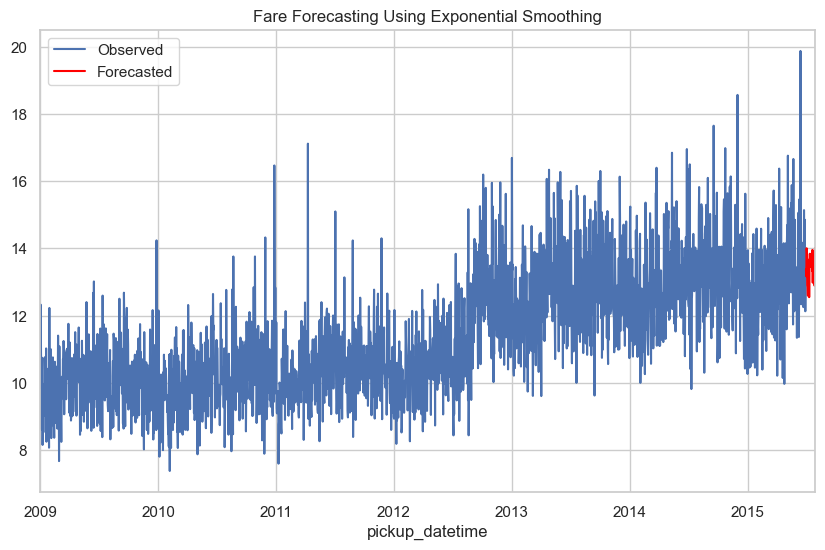

In [63]:
# Plotting actual vs forecasted fares
plt.figure(figsize=(10,6))
fare_series.plot(label='Observed')
forecast.plot(label='Forecasted', color='red')
plt.title('Fare Forecasting Using Exponential Smoothing')
plt.legend()
plt.show()

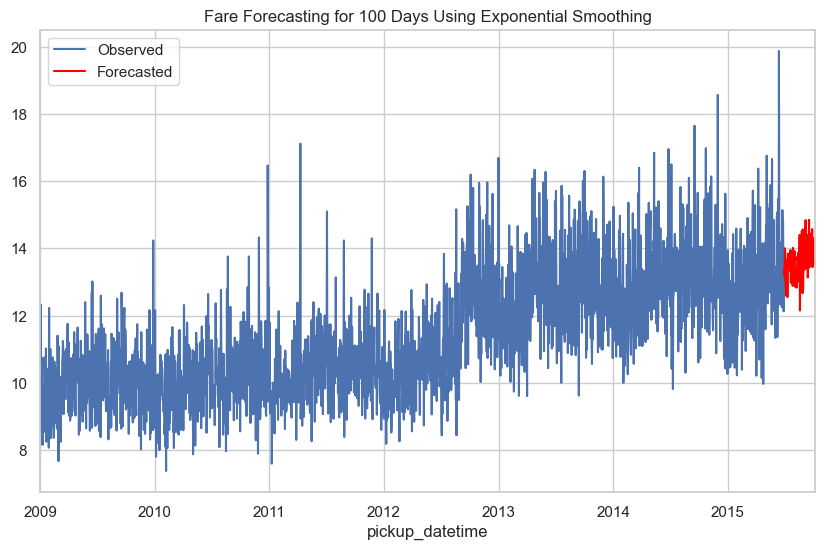

In [71]:
# Forecasting for the next 100 days instead of 30
forecast = fit_model.forecast(steps=100)

# Plotting actual vs forecasted fares for a longer period
plt.figure(figsize=(10,6))
fare_series.plot(label='Observed')
forecast.plot(label='Forecasted', color='red')
plt.title('Fare Forecasting for 100 Days Using Exponential Smoothing')
plt.legend()
plt.show()

In [76]:
!pip install pmdarima

   ---------------------------------------- 0.0/625.1 kB ? eta -:--:--
   ---------------- ----------------------- 262.1/625.1 kB ? eta -:--:--
   ---------------------------------------- 625.1/625.1 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 2.8 MB/s eta 0:00:01
   ----------------------- ---------------- 1.6/2.7 MB 4.0 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 4.5 MB/s eta 0:00:00


In [78]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#  2. ARIMA Model

In [81]:
# Prepare the fare series for ARIMA (resampling daily data)
fare_series = df['fare_amount'].resample('D').mean().fillna(method='ffill')

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10088\350575983.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fare_series = df['fare_amount'].resample('D').mean().fillna(method='ffill')


In [83]:
# Fit the ARIMA model
# p=5 (AR terms), d=1 (differencing), q=2 (MA terms) are example values, you may use auto_arima for better parameter selection
arima_model = ARIMA(fare_series, order=(5, 1, 2))
arima_fit = arima_model.fit()

P:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [85]:
# Forecasting for the next 100 days
forecast_arima = arima_fit.forecast(steps=100)

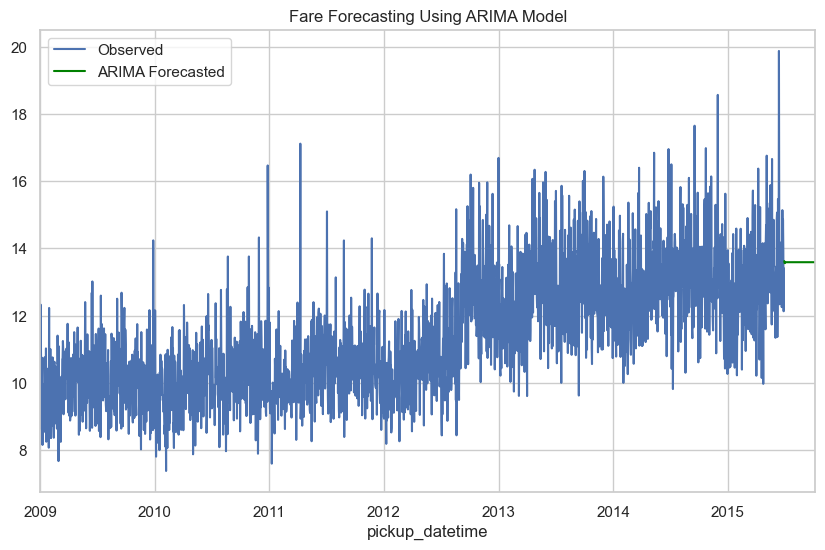

In [87]:
# Plotting actual vs forecasted values using ARIMA
plt.figure(figsize=(10,6))
fare_series.plot(label='Observed')
forecast_arima.plot(label='ARIMA Forecasted', color='green')
plt.title('Fare Forecasting Using ARIMA Model')
plt.legend()
plt.show()

#  3. SARIMA Model

In [90]:
# Fit the SARIMA model (p, d, q) * (P, D, Q, S)
# S=365 represents yearly seasonality for daily data
sarima_model = SARIMAX(fare_series, order=(5, 1, 2), seasonal_order=(1, 1, 1, 7))  # Weekly seasonality

In [92]:
sarima_fit = sarima_model.fit()

P:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
P:\Users\Lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [93]:
# Forecasting for the next 100 days using SARIMA
forecast_sarima = sarima_fit.get_forecast(steps=100)
forecast_sarima_ci = forecast_sarima.conf_int()  # Confidence intervals for the forecast

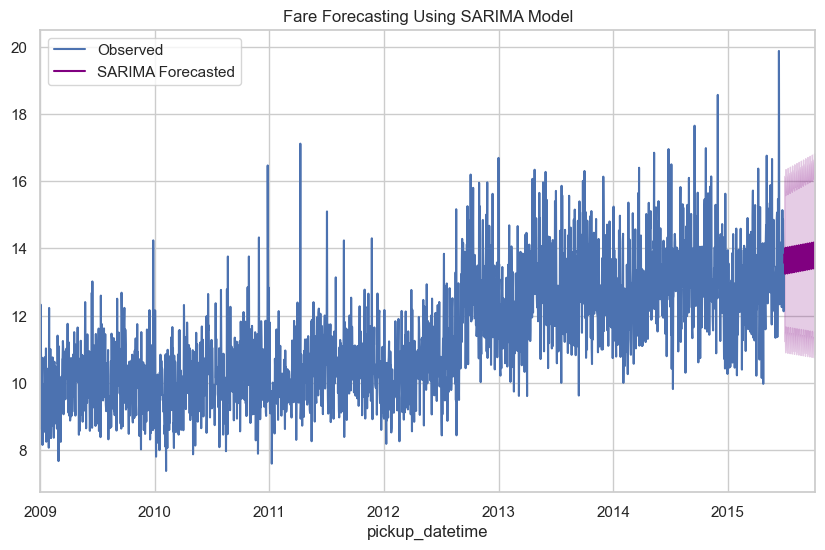

In [96]:
# Plotting actual vs forecasted values using SARIMA
plt.figure(figsize=(10,6))
fare_series.plot(label='Observed')
forecast_sarima.predicted_mean.plot(label='SARIMA Forecasted', color='purple')

# Adding confidence intervals to the plot
plt.fill_between(forecast_sarima_ci.index,
                 forecast_sarima_ci.iloc[:, 0],
                 forecast_sarima_ci.iloc[:, 1],
                 color='purple', alpha=0.2)

plt.title('Fare Forecasting Using SARIMA Model')
plt.legend()
plt.show()

In [98]:
# SARIMA Model summary
print(sarima_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         fare_amount   No. Observations:                 2372
Model:             SARIMAX(5, 1, 2)x(1, 1, [1], 7)   Log Likelihood               -3777.733
Date:                             Sat, 06 Sep 2025   AIC                           7575.465
Time:                                     15:00:58   BIC                           7633.146
Sample:                                 01-01-2009   HQIC                          7596.466
                                      - 06-30-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7112      5.001     -0.142      0.887     -10.513       9.091
ar.L2          0.0114      

#  4. Auto ARIMA for Automatic Parameter Selection

In [101]:
# Using Auto ARIMA for automatic parameter selection
auto_arima_model = pm.auto_arima(fare_series, seasonal=True, m=7,  # Weekly seasonality
                                  max_p=3, max_q=3, max_P=2, max_Q=2,  # Limit orders
                                  stepwise=True, trace=True)

P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Us

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=10.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=9167.781, Time=0.14 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=8479.864, Time=0.73 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=7621.487, Time=2.93 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=9165.783, Time=0.07 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=7623.383, Time=0.77 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=8.32 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=7623.049, Time=9.62 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=7621.360, Time=1.70 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=7622.636, Time=4.03 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=19.14 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=9161.764, Time=0.45 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=7623.262, Time=3.03 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=7623.261, Time=1.70 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=7625.326, Time=2.33 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=7621.043, Time=0.59 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[7]             : AIC=7623.018, Time=0.33 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=7622.318, Time=1.09 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=3.65 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7]             : AIC=7621.168, Time=0.64 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=8.12 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=9159.766, Time=0.16 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=7622.921, Time=0.71 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(1,0,0)[7]             : AIC=7622.920, Time=0.67 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=8477.866, Time=0.38 sec


P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(1,0,0)[7]             : AIC=7625.017, Time=1.00 sec

Best model:  ARIMA(0,1,1)(1,0,0)[7]          
Total fit time: 83.341 seconds


In [103]:
# Fitting the auto_arima model
auto_arima_fit = auto_arima_model.fit(fare_series)

P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [105]:
# Forecasting for the next 100 days
forecast_auto_arima = auto_arima_fit.predict(n_periods=100)

P:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


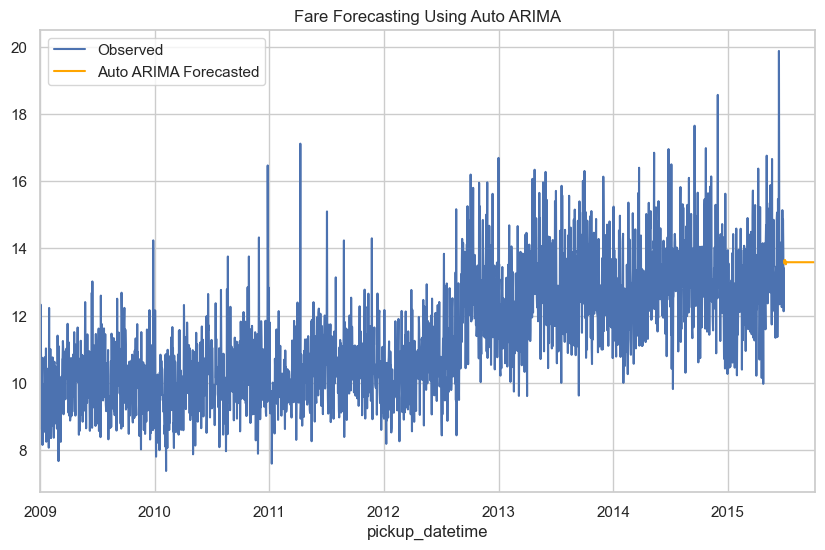

In [107]:
# Plotting actual vs forecasted values using Auto ARIMA
plt.figure(figsize=(10,6))
fare_series.plot(label='Observed')
pd.Series(forecast_auto_arima, index=pd.date_range(start=fare_series.index[-1] + pd.Timedelta(days=1),
                                                   periods=100)).plot(label='Auto ARIMA Forecasted', color='orange')
plt.title('Fare Forecasting Using Auto ARIMA')
plt.legend()
plt.show()

In [109]:
# Auto ARIMA Model summary
print(auto_arima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 2372
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 7)   Log Likelihood               -3807.522
Date:                            Sat, 06 Sep 2025   AIC                           7621.043
Time:                                    15:03:50   BIC                           7638.356
Sample:                                01-01-2009   HQIC                          7627.346
                                     - 06-30-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9507      0.006   -152.650      0.000      -0.963      -0.939
ar.S.L7        0.0421      0.020   

#  LSTM Model for Time Series Forecasting

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [114]:
# Initialize MinMaxScaler and fit to fare data
scaler = MinMaxScaler(feature_range=(0, 1))
fare_scaled = scaler.fit_transform(fare_series.values.reshape(-1, 1))

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(fare_scaled) * 0.8)
train_data = fare_scaled[:train_size]
test_data = fare_scaled[train_size:]

In [116]:
# Function to create sequences of data for LSTM
def create_sequences(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])  # past 60 time steps
        y.append(data[i + time_step, 0])      # the next value
    return np.array(X), np.array(y)

# Create sequences from training and testing data
time_step = 60
X_train, y_train = create_sequences(train_data, time_step)
X_test, y_test = create_sequences(test_data, time_step)

# Reshape the input to 3D for LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [118]:
# Build the LSTM model
model = Sequential()

In [120]:
# Adding the first LSTM layer with dropout regularization
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))

# Adding the output layer (single value prediction)
model.add(Dense(units=1))

P:\Users\Lenovo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [122]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [124]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - loss: 0.0190 - val_loss: 0.0156
Epoch 2/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0094 - val_loss: 0.0149
Epoch 3/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0094 - val_loss: 0.0131
Epoch 4/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0095 - val_loss: 0.0164
Epoch 5/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.0096 - val_loss: 0.0137
Epoch 6/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0093 - val_loss: 0.0137
Epoch 7/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0093 - val_loss: 0.0132
Epoch 8/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0092 - val_loss: 0.0130
Epoch 9/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0091 - val_loss: 0.0136
Epoch 10/10
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0091 - val_loss: 0.0135


In [125]:
# Predict using the test data
predicted_fare = model.predict(X_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step 


In [126]:
# Inverse scaling to get predictions in original scale
predicted_fare = scaler.inverse_transform(predicted_fare)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

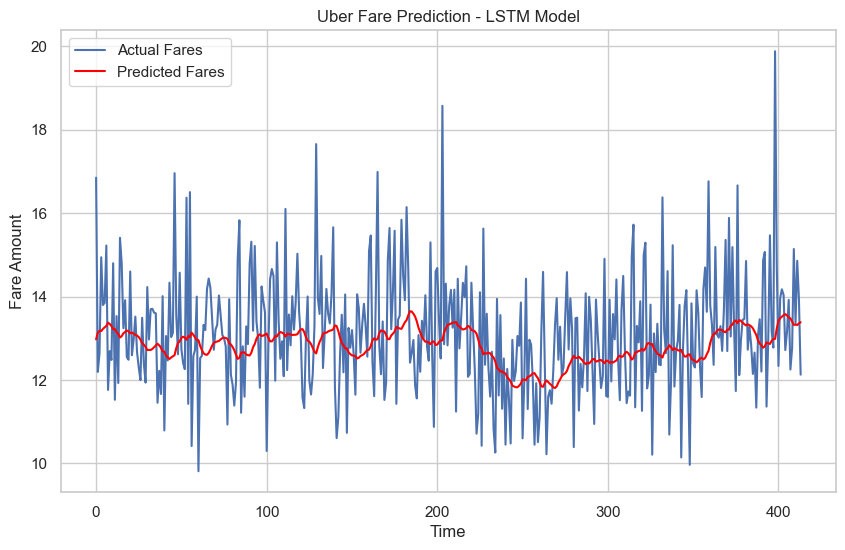

In [127]:
# Plot the actual vs predicted fares
plt.figure(figsize=(10,6))
plt.plot(y_test_original, label='Actual Fares')
plt.plot(predicted_fare, label='Predicted Fares', color='red')
plt.title('Uber Fare Prediction - LSTM Model')
plt.xlabel('Time')
plt.ylabel('Fare Amount')
plt.legend()
plt.show()

Forecast Future Fares

In [133]:
# Forecasting the next 30 days
last_sequence = fare_scaled[-time_step:]  # last 60 time steps
forecasted_fares = []

for i in range(30):  # Predict for 30 days
    next_fare = model.predict(last_sequence.reshape(1, time_step, 1))
    forecasted_fares.append(next_fare[0, 0])

    # Append the predicted fare to the sequence and remove the first value
    last_sequence = np.append(last_sequence[1:], next_fare)

# Inverse transform the forecasted fares
forecasted_fares = scaler.inverse_transform(np.array(forecasted_fares).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━

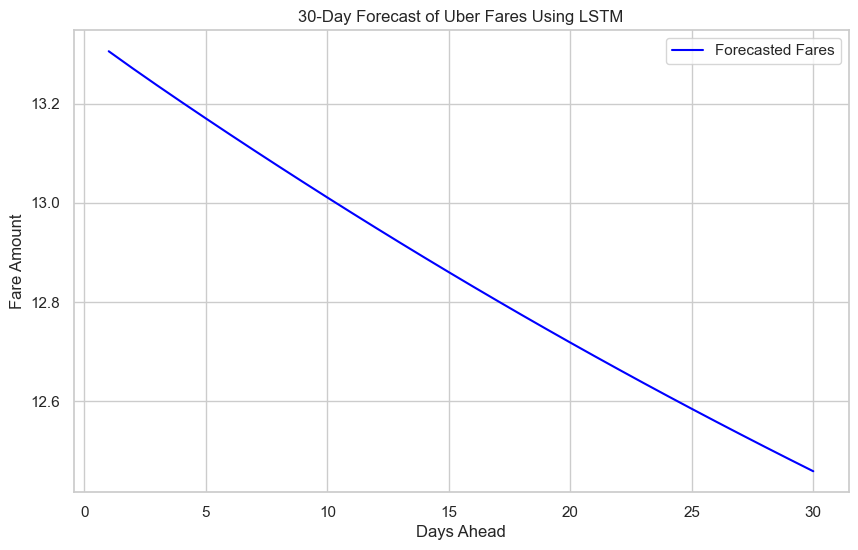

In [135]:
# Plot the forecasted fares
plt.figure(figsize=(10,6))
plt.plot(range(1, 31), forecasted_fares, label='Forecasted Fares', color='blue')
plt.title('30-Day Forecast of Uber Fares Using LSTM')
plt.xlabel('Days Ahead')
plt.ylabel('Fare Amount')
plt.legend()
plt.show()

In [137]:
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_original, predicted_fare))
mae = mean_absolute_error(y_test_original, predicted_fare)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 1.4515728156606726
Mean Absolute Error: 1.111701573335612
